In [2]:
import joblib
from nltk.corpus import stopwords
import string
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import pickle
import nltk
import numpy as np


nltk.download('stopwords')

stemmer = SnowballStemmer("english", ignore_stopwords=True)
token = RegexpTokenizer(r'[a-zA-Z0-9]+')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:

# importing the dataset
# DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "tweet"]
DATASET_ENCODING = "ISO-8859-1"
# dataset = pd.read_csv('./training.1600000.processed.noemoticon.csv', delimiter=',', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# dataset = pd.read_csv('./Corona_NLP_train.csv', delimiter=',', encoding=DATASET_ENCODING)
dataset = pd.read_csv('./IMDB Dataset.csv', delimiter=',', encoding=DATASET_ENCODING)

# removing the unnecessary columns and duplicates
# dataset = dataset[['OriginalTweet','Sentiment']]
# dataset = dataset[['tweet','sentiment']]
dataset = dataset[['review','sentiment']]
dataset.drop_duplicates()

token = RegexpTokenizer(r'[a-zA-Z0-9]+')


dataset.head()



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:


# Preprocessing


def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)


def remove_mention(text):
    return re.sub("@[A-Za-z0-9]+", "", text)


def stem_tweets(tweet):
    tokens = tweet.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)


# remove stopwords


stop = set(stopwords.words("english"))


def remove_stopwords(text):
    stop = set(stopwords.words("english"))

    filtered_words = [word.lower()
                      for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)


def preprocess_tweets(tweet):
    tweet = remove_mention(tweet)
    tweet = remove_URL(tweet)
    tweet = remove_punct(tweet)
    tweet = stem_tweets(tweet)
    tweet = remove_stopwords(tweet)
    return tweet

In [6]:

X = dataset['review']
# X = dataset['tweet']
# X = dataset['OriginalTweet']

X = X.apply(preprocess_tweets)

y = dataset['sentiment']
# y = dataset['Sentiment']
X

0        one review mention watch 1 oz episod youll hoo...
1        wonder littl product br br film techniqu unass...
2        thought wonder way spend time hot summer weeke...
3        basic famili littl boy jake think zombi closet...
4        petter mattei love time money visual stun film...
                               ...                        
49995    thought movi right good job wasnt creativ orig...
49996    bad plot bad dialogu bad act idiot direct anno...
49997    cathol taught parochi elementari school nun ta...
49998    im go disagre previous comment side maltin one...
49999    one expect star trek movi high art fan expect ...
Name: review, Length: 50000, dtype: object

In [8]:

tfidf = pickle.load(open(f"./vectors/imdb/tfidf_mnb_87", "rb"))


In [9]:

X = tfidf.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((40000, 20000), (40000,))

In [10]:
X

<50000x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 4430168 stored elements in Compressed Sparse Row format>

C:\Users\Enes\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

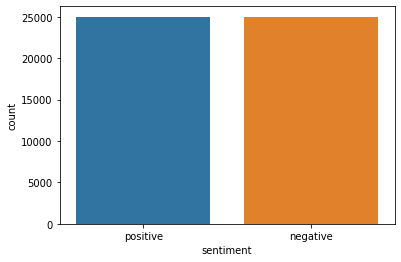

In [11]:
sns.countplot(y)

Text(0.5, 1.0, 'Positive words cloud')

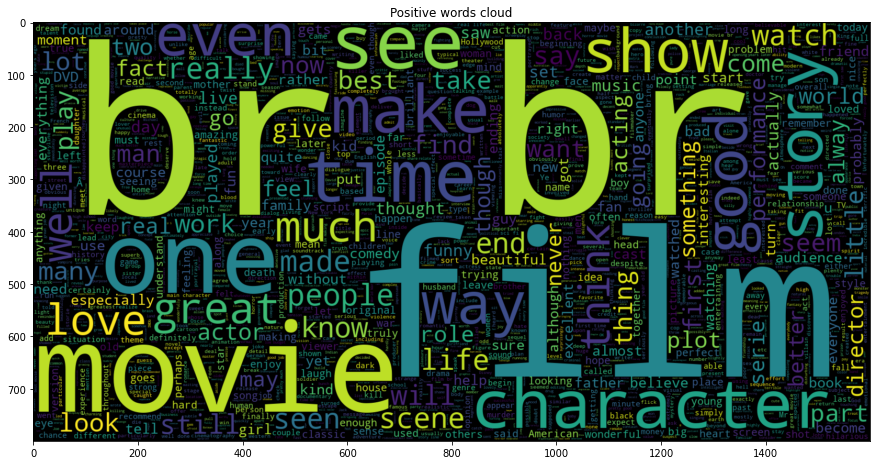

In [12]:
plt.figure(figsize = (15,15)) 
options = ['Positive', 'Extremely Positive', 'positive']
cond = dataset['sentiment'].isin(options)
result = dataset[cond].review.values
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(result))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Positive words cloud')

Text(0.5, 1.0, 'Negative words cloud')

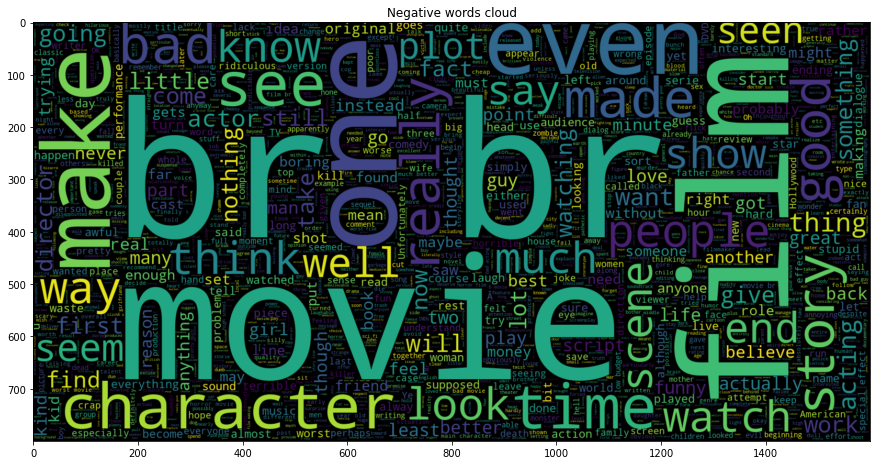

In [13]:
plt.figure(figsize = (15,15)) 
options = ['Negative', 'Extremely Negative', 'negative']
cond = dataset['sentiment'].isin(options)
result = dataset[cond].review.values
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(result))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Negative words cloud')

In [14]:

# creating our pipeline that will return an estimator
pipeline = Pipeline([('clf', MultinomialNB())])


In [15]:

parameters = {
    'clf__alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
    }

clf = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy', cv=5)

clf = clf.fit(X_train, y_train)


In [16]:

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.86      0.85      0.85      4961
    positive       0.85      0.86      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [17]:

print("Best: %f using %s" % (clf.best_score_, 
    clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.853950 using {'clf__alpha': 1}
0.853950 (0.002772) with: {'clf__alpha': 1}
0.853325 (0.002978) with: {'clf__alpha': 0.1}
0.853425 (0.002827) with: {'clf__alpha': 0.01}
0.853175 (0.002962) with: {'clf__alpha': 0.001}
0.852975 (0.002950) with: {'clf__alpha': 0.0001}
0.852975 (0.003016) with: {'clf__alpha': 1e-05}


In [18]:

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

acc = int(accuracy_score(y_test, y_pred)*100)


[[4199  762]
 [ 692 4347]]


In [19]:

# exporting the pipeline
pickle.dump(clf, open('./models/MNB_model_{acc}', 'wb'))